In [1]:
# import cv2
# import mediapipe as mp
# import numpy as np

# mp_pose = mp.solutions.pose
# pose = mp_pose.Pose()

# # Load necklace image with transparency
# necklace = cv2.imread("necklase1.png", cv2.IMREAD_UNCHANGED)

# # Ensure alpha channel exists
# def ensure_alpha(image):
#     if image is None:
#         print("Error: Necklace image not found!")
#         return None
#     if image.shape[-1] == 3:  # Convert BGR to BGRA if needed
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
#     return image

# necklace = ensure_alpha(necklace)

# # Remove background and keep only necklace
# def remove_background(image):
#     gray = cv2.cvtColor(image[:, :, :3], cv2.COLOR_BGR2GRAY)
#     _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
#     alpha = mask.astype(np.uint8)
#     image[:, :, 3] = alpha
#     return image

# necklace = remove_background(necklace)

# # Overlay necklace with proper alpha blending
# def overlay_image(background, overlay, x, y, width, height):
#     if overlay is None or background is None:
#         return background

#     overlay = cv2.resize(overlay, (width, height))
#     alpha_mask = overlay[:, :, 3] / 255.0
#     alpha_inv = 1.0 - alpha_mask

#     h, w, _ = background.shape
#     x1, x2 = max(0, x), min(w, x + width)
#     y1, y2 = max(0, y), min(h, y + height)

#     if x1 >= x2 or y1 >= y2:
#         return background

#     overlay = overlay[: y2 - y1, : x2 - x1]
#     alpha_mask = alpha_mask[: y2 - y1, : x2 - x1]
#     alpha_inv = alpha_inv[: y2 - y1, : x2 - x1]

#     alpha_mask = np.stack([alpha_mask] * 3, axis=-1)
#     alpha_inv = np.stack([alpha_inv] * 3, axis=-1)

#     background[y1:y2, x1:x2, :3] = (
#         alpha_inv * background[y1:y2, x1:x2, :3] + alpha_mask * overlay[:, :, :3]
#     ).astype(np.uint8)

#     return background

# cap = cv2.VideoCapture(0)

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     pose_result = pose.process(frame_rgb)

#     if pose_result.pose_landmarks:
#         landmarks = pose_result.pose_landmarks.landmark
#         left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
#         right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
#         nose = landmarks[mp_pose.PoseLandmark.NOSE]  # Use nose to estimate neck

#         if left_shoulder and right_shoulder and nose:
#             x1, y1 = int(left_shoulder.x * frame.shape[1]), int(left_shoulder.y * frame.shape[0])
#             x2, y2 = int(right_shoulder.x * frame.shape[1]), int(right_shoulder.y * frame.shape[0])

#             # Midpoint of shoulders (better horizontal positioning)
#             center_x = (x1 + x2) // 2
#             shoulder_width = abs(x2 - x1)

#             # Estimate neck position (slightly below the nose)
#             neck_y = int(nose.y * frame.shape[0] + shoulder_width * 0.2)  

#             # Adjust necklace size dynamically
#             width = int(shoulder_width * 1.1)  
#             height = int(width * 0.4)  

#             x = max(0, center_x - width // 2)
#             y = max(0, neck_y)  

#             frame = overlay_image(frame, necklace, x, y, width, height)

#     cv2.imshow("Necklace Try-On", frame)

#     if cv2.waitKey(1) & 0xFF in [ord("q"), 27]:  
#         break

# cap.release()
# cv2.destroyAllWindows()


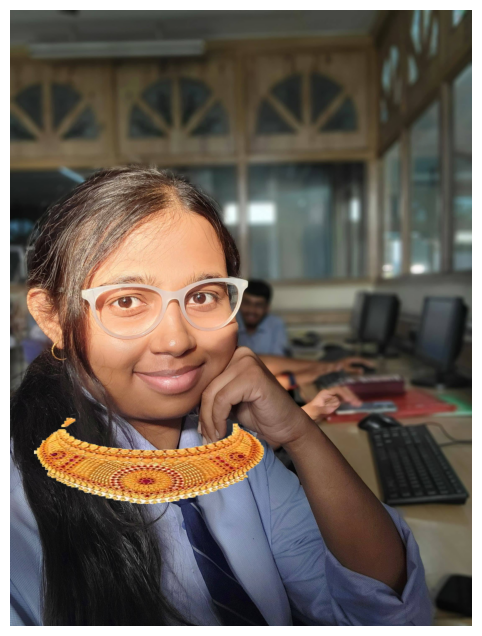

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt

# Initialize Tkinter (for file selection dialog)
root = tk.Tk()
root.withdraw()  # Hide the root window

# Open file selection dialog
input_image_path = filedialog.askopenfilename(title="Select an Image",
                                              filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])

if not input_image_path:
    print("Error: No file selected.")
    exit()

# Load selected image
frame = cv2.imread(input_image_path)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1, smooth_landmarks=True)

# Load necklace image with transparency
necklace = cv2.imread("necklase1.png", cv2.IMREAD_UNCHANGED)

def ensure_alpha(image):
    """Ensures that the image has an alpha channel (BGRA format)."""
    if image is None:
        print("Error: Necklace image not found!")
        return None
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)  # Convert BGR to BGRA if needed
    return image

necklace = ensure_alpha(necklace)

def remove_background(image):
    """Removes the white background and keeps only the necklace using advanced masking."""
    gray = cv2.cvtColor(image[:, :, :3], cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)  

    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    image[:, :, 3] = mask.astype(np.uint8)
    return image

necklace = remove_background(necklace)

def overlay_image(background, overlay, x, y, width, height):
    """Overlays an image with proper alpha blending."""
    if overlay is None or background is None:
        return background

    overlay = cv2.resize(overlay, (width, height))
    alpha_mask = overlay[:, :, 3] / 255.0
    alpha_inv = 1.0 - alpha_mask

    h, w, _ = background.shape
    x1, x2 = max(0, x), min(w, x + width)
    y1, y2 = max(0, y), min(h, y + height)

    if x1 >= x2 or y1 >= y2:
        return background

    overlay = overlay[: y2 - y1, : x2 - x1]
    alpha_mask = alpha_mask[: y2 - y1, : x2 - x1]
    alpha_inv = alpha_inv[: y2 - y1, : x2 - x1]

    alpha_mask = np.stack([alpha_mask] * 3, axis=-1)
    alpha_inv = np.stack([alpha_inv] * 3, axis=-1)

    background[y1:y2, x1:x2, :3] = (
        alpha_inv * background[y1:y2, x1:x2, :3] + alpha_mask * overlay[:, :, :3]
    ).astype(np.uint8)

    return background

# Process the image
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
pose_result = pose.process(frame_rgb)

if pose_result.pose_landmarks:
    landmarks = pose_result.pose_landmarks.landmark
    left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    nose = landmarks[mp_pose.PoseLandmark.NOSE]

    if left_shoulder and right_shoulder and nose:
        x1, y1 = int(left_shoulder.x * frame.shape[1]), int(left_shoulder.y * frame.shape[0])
        x2, y2 = int(right_shoulder.x * frame.shape[1]), int(right_shoulder.y * frame.shape[0])
        nose_x, nose_y = int(nose.x * frame.shape[1]), int(nose.y * frame.shape[0])

        # Midpoint of shoulders
        center_x = (x1 + x2) // 2
        shoulder_width = abs(x2 - x1)

        # **Mid-neck position** (between nose and chest)
        mid_neck_y = int(nose_y + (y1 - nose_y) * 0.7)  # Position in the middle of the neck

        # Adjust necklace position
        neck_y = mid_neck_y + int(shoulder_width * 0.1)  # Slight offset for better fit

        # Adjust necklace size
        width = int(shoulder_width * 1.0)  # Natural fit width
        height = int(width * 0.4)  # Proportional height

        x = max(0, center_x - width // 2)
        y = max(0, neck_y)

        frame = overlay_image(frame, necklace, x, y, width, height)

# Convert BGR to RGB for Jupyter Notebook display
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the output in Jupyter Notebook
plt.figure(figsize=(8, 8))
plt.imshow(frame_rgb)
plt.axis("off")
plt.show()
